In [ ]:
!git clone https://github.com/aimacode/aima-python.git
%cd aima-python
!pip install -r requirements.txt
!git submodule init
!git submodule update
!pip install -r requirements.txt
!pip install -r requirements.txt

Cloning into 'aima-python'...
remote: Enumerating objects: 5095, done.
remote: Total 5095 (delta 0), reused 0 (delta 0), pack-reused 5095
Receiving objects: 100% (5095/5095), 17.44 MiB | 25.54 MiB/s, done.
Resolving deltas: 100% (3418/3418), done.
/content/aima-python/aima-python
Submodule 'aima-data' (https://github.com/aimacode/aima-data.git) registered for path 'aima-data'
Cloning into '/content/aima-python/aima-python/aima-data'...
Submodule path 'aima-data': checked out 'f6cbea61ad0c21c6b7be826d17af5a8d3a7c2c86'


In [ ]:
!git submodule init
!git submodule update

!pip install pytest
!pytest

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.3, pluggy-1.3.0
rootdir: /content/aima-python/aima-python
configfile: pytest.ini
plugins: cov-4.1.0, anyio-3.7.1
collected 419 items                                                                                

tests/test_agents.py ................                                                        [  3%]
tests/test_agents4e.py ................                                                      [  7%]
tests/test_csp.py ........................................

#CPSC 481 - Artificial Intelligence
Project 3 - Fall 2023

#Mike Ball - 886933274

#Randall Frye - 888733896

#Harshita Mhaske - 885191973

#Lillian Hoang -

#Nelson Phan - 886754035

#James Thyen - 802175901

**Approach** -

At first, it seems like the likelihood_weighting() function provided by the textbook in principle is what our inference algorithm needs to be. It uses the weighted_sample() function to create a sample of a Bayesian network given evidence. However the code is not very readable, and it’s not clear what classes/functions are necessary to use in order to execute the inference algorithm.

We used the likelihood_weighting() function to quickly generate answers for the 5 queries using random sampling. We had some semantic problems with passing a dictionary item in as evidence, but other than that, it seemed to do it correctly. But it seemed too simple to be true. Perhaps the difficulty lies with full_joint_probability distribution.


**Diagram**



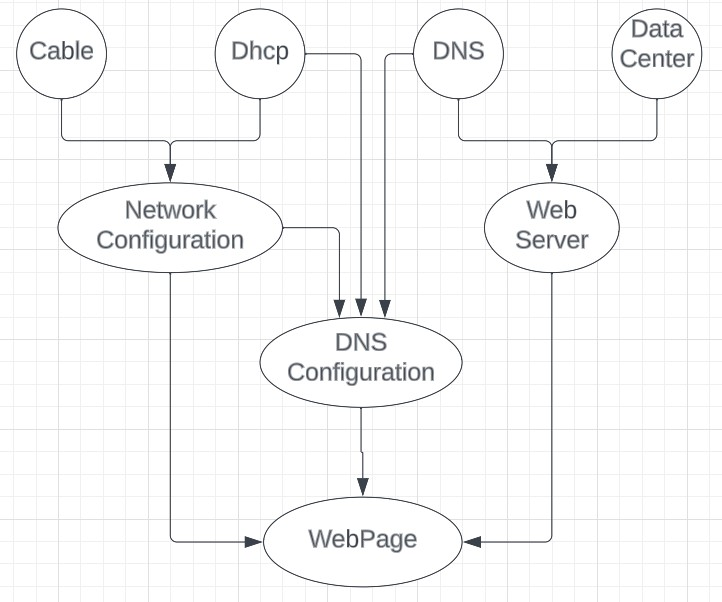

In [ ]:
from collections import defaultdict
from functools import reduce
import numpy as np
import random

class ProbDist:
    """A discrete probability distribution. You name the random variable
    in the constructor, then assign and query probability of values.
    >>> P = ProbDist('Flip'); P['H'], P['T'] = 0.25, 0.75; P['H']
    0.25
    >>> P = ProbDist('X', {'lo': 125, 'med': 375, 'hi': 500})
    >>> P['lo'], P['med'], P['hi']
    (0.125, 0.375, 0.5)
    """

    def __init__(self, var_name='?', freq=None):
        """If freq is given, it is a dictionary of values - frequency pairs,
        then ProbDist is normalized."""
        self.prob = {}
        self.var_name = var_name
        self.values = []
        if freq:
            for (v, p) in freq.items():
                self[v] = p
            self.normalize()

    def __getitem__(self, val):
        """Given a value, return P(value)."""
        try:
            return self.prob[val]
        except KeyError:
            return 0

    def __setitem__(self, val, p):
        """Set P(val) = p."""
        if val not in self.values:
            self.values.append(val)
        self.prob[val] = p

    def normalize(self):
        """Make sure the probabilities of all values sum to 1.
        Returns the normalized distribution.
        Raises a ZeroDivisionError if the sum of the values is 0."""
        total = sum(self.prob.values())
        if not np.isclose(total, 1.0):
            for val in self.prob:
                self.prob[val] /= total
        return self

    def show_approx(self, numfmt='{:.3g}'):
        """Show the probabilities rounded and sorted by key, for the
        sake of portable doctests."""
        return ', '.join([('{}: ' + numfmt).format(v, p) for (v, p) in sorted(self.prob.items())])

    def __repr__(self):
        return "P({})".format(self.var_name)

#This does not actually sample from the distribution, but rather returns a sample that is consistent with the evidence.
def weighted_sample(bn, e):
    """Sample an event from bn that's consistent with the evidence e;
    return the event and its weight, the likelihood that the event
    accords to the evidence."""

    #The weight represents the likelihood that a random sample would be consistent with the evidence.
    #So, for example, if the list of evidence is very long, that means a random sample is very unlikely to satisfy
    #all of the evidence conditions, and the weight would be very small.
    w = 1
    #creates a copy of the evidence 'e' as a dictionary named event.
    event = dict(e)  # boldface x in [Figure 14.15]

    #Iterates over all nodes in the bayesian network
    for node in bn.nodes:
        #gets the variable associated with the current node
        Xi = node.variable

        #checks if the variable is in the evidence
        if Xi in e:
            #if the variable associated with the node is in the evidence, then the weight is multiplied by the probability of the variable given the evidence.
            w *= node.p(e[Xi], event)
        #if var is not in evidence
        else:
            #samples the variable given the evidence. Evidence might make the sample deterministic, or change the probability distribution.
            event[Xi] = node.sample(event)
    return event, w

#checks that the random sample is consistent with the specifically defined pieces of evidence.
#For example, if a provided piece of evidence is that the alarm is going off, then the sample must have the alarm going off.
def consistent_with(event, evidence):
    """Is event consistent with the given evidence?"""
    return all(evidence.get(k, v) == v
               for k, v in event.items())


def likelihood_weighting(X, e, bn, N=10000):
    """Estimate the probability distribution of variable X given
    evidence e in BayesNet bn.  [Figure 14.15]
    >>> random.seed(1017)
    >>> likelihood_weighting('Burglary', dict(JohnCalls=T, MaryCalls=T),
    ...   burglary, 10000).show_approx()
    'False: 0.702, True: 0.298'
    """
    W = {x: 0 for x in bn.variable_values(X)}
    for j in range(N):
        sample, weight = weighted_sample(bn, e)  # boldface x, w in [Figure 14.15]
        W[sample[X]] += weight
    return ProbDist(X, W)

def prior_sample(bn):
    """Randomly sample from bn's full joint distribution. The result
    is a {variable: value} dict. [Figure 14.13]"""
    event = {}
    for node in bn.nodes:
        event[node.variable] = node.sample(event)
    return event

def extend(s, var, val):
    """Copy dict s and extend it by setting var to val; return copy."""
    return {**s, var: val}

def event_values(event, variables):
    """Return a tuple of the values of variables in event.
    >>> event_values ({'A': 10, 'B': 9, 'C': 8}, ['C', 'A'])
    (8, 10)
    >>> event_values ((1, 2), ['C', 'A'])
    (1, 2)
    """
    if isinstance(event, tuple) and len(event) == len(variables):
        return event
    else:
        return tuple([event[var] for var in variables])

def probability(p):
    """Return true with probability p."""
    return p > random.uniform(0.0, 1.0)

def enumerate_all(variables, e, bn):
    """Return the sum of those entries in P(variables | e{others})
    consistent with e, where P is the joint distribution represented
    by bn, and e{others} means e restricted to bn's other variables
    (the ones other than variables). Parents must precede children in variables."""
    if not variables:
        return 1.0
    Y, rest = variables[0], variables[1:]
    Ynode = bn.variable_node(Y)
    if Y in e:
        return Ynode.p(e[Y], e) * enumerate_all(rest, e, bn)
    else:
        return sum(Ynode.p(y, e) * enumerate_all(rest, extend(e, Y, y), bn)
                   for y in bn.variable_values(Y))


class BayesNet:
    """Bayesian network containing only boolean-variable nodes."""

    def __init__(self, node_specs=None):
        """Nodes must be ordered with parents before children."""
        self.nodes = []
        self.variables = []
        node_specs = node_specs or []
        for node_spec in node_specs:
            self.add(node_spec)

    def print_network(self):
        """Print the structure of the Bayesian network."""
        for node in self.nodes:
            print(f"Node: {node.variable}, Parents: {node.parents}, CPT: {node.cpt}")

    def add(self, node_spec):
        """Add a node to the net. Its parents must already be in the
        net, and its variable must not."""
        node = BayesNode(*node_spec)
        assert node.variable not in self.variables
        assert all((parent in self.variables) for parent in node.parents)
        self.nodes.append(node)
        self.variables.append(node.variable)
        for parent in node.parents:
            self.variable_node(parent).children.append(node)

    def variable_node(self, var):
        """Return the node for the variable named var.
        >>> burglary.variable_node('Burglary').variable
        'Burglary'"""
        for n in self.nodes:
            if n.variable == var:
                return n
        raise Exception("No such variable: {}".format(var))

    def show_child_node_values(self, variable):
        """Show the probabilities associated with combinations of values for child nodes."""
        variable_node = self.variable_node(variable)

        # Extract child nodes and their conditional probability tables (CPTs)
        child_nodes = variable_node.children

        # Display probabilities for each child node
        for child_node in child_nodes:
            child_variable = child_node.variable
            cpt = child_node.cpt

        # Display probabilities for each combination of values
        print(f"Child Node: {child_variable}, Conditional Probabilities:")
        for values, probability in cpt.items():
            print(f"  Values: {values}, Probability: {probability}")

    def get_probability_for_values(self, variable, child_values):
        """Get the probability for a variable given the boolean values of its children."""
        variable_node = self.variable_node(variable)

        # Check if the number of child values matches the number of parents in the variable node
        if len(child_values) != len(variable_node.parents):
            raise ValueError("Number of child values must match the number of parents for the variable.")

        # Convert child values to a tuple to match the format of the CPT keys
        values_tuple = tuple(child_values)

        # Get the probability from the conditional probability table (CPT) of the variable node
        probability = variable_node.cpt[values_tuple]

        return probability

    def variable_values(self, var):
        """Return the domain of var."""
        return [True, False]

    def __repr__(self):
        return 'BayesNet({0!r})'.format(self.nodes)

class BayesNode:
    """A conditional probability distribution for a boolean variable,
    P(X | parents). Part of a BayesNet."""

    def __init__(self, X, parents, cpt):
        """X is a variable name, and parents a sequence of variable
        names or a space-separated string.  cpt, the conditional
        probability table, takes one of these forms:

        * A number, the unconditional probability P(X=true). You can
          use this form when there are no parents.

        * A dict {v: p, ...}, the conditional probability distribution
          P(X=true | parent=v) = p. When there's just one parent.

        * A dict {(v1, v2, ...): p, ...}, the distribution P(X=true |
          parent1=v1, parent2=v2, ...) = p. Each key must have as many
          values as there are parents. You can use this form always;
          the first two are just conveniences.

        In all cases the probability of X being false is left implicit,
        since it follows from P(X=true).

        >>> X = BayesNode('X', '', 0.2)
        >>> Y = BayesNode('Y', 'P', {T: 0.2, F: 0.7})
        >>> Z = BayesNode('Z', 'P Q',
        ...    {(T, T): 0.2, (T, F): 0.3, (F, T): 0.5, (F, F): 0.7})
        """
        if isinstance(parents, str):
            parents = parents.split()

        # We store the table always in the third form above.
        if isinstance(cpt, (float, int)):  # no parents, 0-tuple
            cpt = {(): cpt}
        elif isinstance(cpt, dict):
            # one parent, 1-tuple
            if cpt and isinstance(list(cpt.keys())[0], bool):
                cpt = {(v,): p for v, p in cpt.items()}

        assert isinstance(cpt, dict)
        for vs, p in cpt.items():
            assert isinstance(vs, tuple) and len(vs) == len(parents)
            assert all(isinstance(v, bool) for v in vs)
            assert 0 <= p <= 1

        self.variable = X
        self.parents = parents
        self.cpt = cpt
        self.children = []

    def p(self, value, event):
        """Return the conditional probability
        P(X=value | parents=parent_values), where parent_values
        are the values of parents in event. (event must assign each
        parent a value.)
        >>> bn = BayesNode('X', 'Burglary', {T: 0.2, F: 0.625})
        >>> bn.p(False, {'Burglary': False, 'Earthquake': True})
        0.375"""
        assert isinstance(value, bool)
        ptrue = self.cpt[event_values(event, self.parents)]
        return ptrue if value else 1 - ptrue

    def sample(self, event):
        """Sample from the distribution for this variable conditioned
        on event's values for parent_variables. That is, return True/False
        at random according with the conditional probability given the
        parents."""
        return probability(self.p(True, event))

    def __repr__(self):
        return repr((self.variable, ' '.join(self.parents)))


T, F = True, False

cable_node = BayesNode('Cable','',0.95)
dhcp_node = BayesNode('Dhcp','',0.85)
dns_node = BayesNode('Dns','',0.70)
dataCenter_node = BayesNode('dataCenter','',0.99)


webserver_node = BayesNode('WebServer', ['Dns', 'DataCenter'],
                           {(True, True): 0.95, (True, False): 0.90,
                            (False, True): 0.10, (False, False): 0.05})

networkconfig_node = BayesNode('NetworkConfig', ['Cable', 'Dhcp'],
                               {(True, True): 0.99, (True, False): 0.50,
                                (False, True): 0.95, (False, False): 0.01})


dnsconfig_node = BayesNode('DnsConfig', ['NetworkConfig', 'Dhcp', 'Dns'],
                           {(True, True, True): 0.99, (True, True, False): 0.85,
                            (True, False, True): 0.70, (True, False, False): 0.40,
                            (False, True, True): 0.95, (False, True, False): 0.90,
                            (False, False, True): 0.75, (False, False, False): 0.50})

webpage_node = BayesNode('WebPage', ['NetworkConfig', 'DnsConfig', 'WebServer'],
                         {(True, True, True): 0.99, (True, True, False): 0.10,
                          (True, False, True): 0.30, (True, False, False): 0.05,
                          (False, True, True): 0.06, (False, True, False): 0.02,
                          (False, False, True): 0.04, (False, False, False): 0.01})


# Initialize BayesNet
network = BayesNet()

# Add nodes to BayesNet
# Add parent nodes first
network.add(('Cable', '', 0.95))
network.add(('Dhcp', '', 0.85))
network.add(('Dns', '', 0.70))
network.add(('DataCenter', '', 0.99))

# Then add child nodes
network.add(('WebServer', ['Dns', 'DataCenter'],
             {(True, True): 0.95, (True, False): 0.90,
              (False, True): 0.10, (False, False): 0.05}))

network.add(('NetworkConfig', ['Cable', 'Dhcp'],
             {(True, True): 0.99, (True, False): 0.50,
              (False, True): 0.95, (False, False): 0.01}))

network.add(('DnsConfig', ['NetworkConfig', 'Dhcp', 'Dns'],
             {(True, True, True): 0.99, (True, True, False): 0.85,
              (True, False, True): 0.70, (True, False, False): 0.40,
              (False, True, True): 0.95, (False, True, False): 0.90,
              (False, False, True): 0.75, (False, False, False): 0.50}))

network.add(('WebPage', ['NetworkConfig', 'DnsConfig', 'WebServer'],
                         {(True, True, True): 0.99, (True, True, False): 0.10,
                          (True, False, True): 0.30, (True, False, False): 0.05,
                          (False, True, True): 0.06, (False, True, False): 0.02,
                          (False, False, True): 0.04, (False, False, False): 0.01}))

#ProbDist example
p = ProbDist(freq={'low': 125, 'medium': 375, 'high': 500})
#print(p['low'], p['medium'], p['high'])

#Likelihood weighting example
random.seed(999)

query_1 = likelihood_weighting('WebPage',{}, network, 100000)[False]
query_2 = likelihood_weighting('WebServer',{}, network, 10000)[False]
query_3 = likelihood_weighting('WebServer',{'WebPage':False}, network, 10000)[False]
query_4 = likelihood_weighting('WebPage',{'Dhcp':False, 'Dns':False}, network, 10000)[True]
query_5 = likelihood_weighting('DataCenter',{'Dns':False, 'WebServer':False}, network, 10000)[True]

#How likely is it that the employee won’t be able to access the web page?
#How likely is the web server to be down?
#If the employee can’t access the web page, how likely is the web server to be down?
#If the DHCP and DNS servers are both down, how likely is it that the employee will be able to access the web page?
#If the web server is down and the PC’s DNS configuration is incorrect, how likely is the data center to be functioning?

print("PROBABILITY WEBPAGE IS DOWN USING LIKELIHOOD WEIGHTING")
print(query_1)
print("PROBABILITY WEBSERVER IS DOWN USING LIKELIHOOD WEIGHTING")
print(query_2)
print("PROBABILITY WEBSERVER IS DOWN GIVEN WEBPAGE IS DOWN USING LIKELIHOOD WEIGHTING (SAMPING ALGORITHM)")
print(query_3)
print("PROBABILITY WEBPAGE IS UP GIVEN DHCP AND DNS ARE DOWN USING LIKELIHOOD WEIGHTING (SAMPLING ALGORITHM)")
print(query_4)
print("PROBABILITY DATACENTER IS UP GIVEN WEBSERVER IS DOWN AND DNS CONFIG IS INCORRECT USING LIKELIHOOD WEIGHTING (SAMPLING ALGORITHM)")
print(query_5)



**Full Joint Distribution**

> First we will create the Full Joint Distrubtion and display it to the console. It is expected that there will be 256 conbinations in the distribution, as there are 8 boolean variables. 2^8 = 256.


> Also, the probabilities associated with all of these should add up to 1. We tested this and they do indeed all add to one.





In [ ]:
from itertools import product

class JointProbDist(ProbDist):
    """A discrete probability distribute over a set of variables.
    >>> P = JointProbDist(['X', 'Y']); P[1, 1] = 0.25
    >>> P[1, 1]
    0.25
    >>> P[dict(X=0, Y=1)] = 0.5
    >>> P[dict(X=0, Y=1)]
    0.5"""

    def __init__(self, variables):
        self.prob = {}
        self.variables = variables
        self.vals = defaultdict(list)

    def __getitem__(self, values):
        """Given a tuple or dict of values, return P(values)."""
        values = event_values(values, self.variables)
        return ProbDist.__getitem__(self, values)

    def __setitem__(self, values, p):
        """Set P(values) = p.  Values can be a tuple or a dict; it must
        have a value for each of the variables in the joint. Also keep track
        of the values we have seen so far for each variable."""
        values = event_values(values, self.variables)
        self.prob[values] = p
        for var, val in zip(self.variables, values):
            if val not in self.vals[var]:
                self.vals[var].append(val)

    def values(self, var):
        """Return the set of possible values for a variable."""
        return self.vals[var]

    def __repr__(self):
        return "P({})".format(self.variables)

def enumerate_joint(variables, e, P):
    """Return the sum of those entries in P consistent with e,
    provided variables is P's remaining variables (the ones not in e)."""
    if not variables:
        return P[e]
    Y, rest = variables[0], variables[1:]
    return sum([enumerate_joint(rest, extend(e, Y, y), P)
                for y in P.values(Y)])

def enumerate_joint_ask(X, e, P):
    """Return a probability distribution over the values of the variable X,
    given the {var:val} observations e, in the JointProbDist P. [Section 13.3]
    >>> P = JointProbDist(['X', 'Y'])
    >>> P[0,0] = 0.25; P[0,1] = 0.5; P[1,1] = P[2,1] = 0.125
    >>> enumerate_joint_ask('X', dict(Y=1), P).show_approx()
    '0: 0.667, 1: 0.167, 2: 0.167'
    """
    assert X not in e, "Query variable must be distinct from evidence"
    Q = ProbDist(X)  # probability distribution for X, initially empty
    Y = [v for v in P.variables if v != X and v not in e]  # hidden variables.
    for xi in P.values(X):
        Q[xi] = enumerate_joint(Y, extend(e, X, xi), P)
    return Q.normalize()

full_joint = JointProbDist(['Cable',"Dhcp","Dns","DataCenter","NetworkConfig","WebServer","DnsConfig","WebPage"])

from itertools import product

# Define the variables in the JointProbDist
variables = ['Cable', 'Dhcp', 'Dns', 'DataCenter', 'NetworkConfig', 'WebServer', 'DnsConfig', 'WebPage']

# Generate all possible combinations of True and False for the variables
combinations = list(product([True, False], repeat=len(variables)))

# Display the combinations
for combination in combinations:
    event_dict = dict(zip(variables, combination))
    print(event_dict)

def generate_full_joint(bayes_net):
    """Generate the full joint distribution for the given BayesNet."""
    all_variables = bayes_net.variables
    full_joint = JointProbDist(all_variables)

    for assignment in product(*[bayes_net.variable_values(variable) for variable in all_variables]):
        evidence = dict(zip(all_variables, assignment))
        probability = enumerate_all(all_variables, evidence, bayes_net)
        full_joint[assignment] = probability

    return full_joint

'''
def query_joint_distribution(full_joint_distribution, evidence):
    """Sum up the probabilities associated with each assignment where the evidence is true."""
    total_probability = 0

    for assignment, probability in full_joint_distribution.prob.items():
        if all(assignment[i] == val for i, val in enumerate(evidence.values())):
            total_probability += probability

    return total_probability
'''
# Example usage
full_joint_distribution = generate_full_joint(network)
print(full_joint_distribution.prob)

**Now that we have the full joint distribution,**

We can use it to answer our queries with the enumerate_joint_ask() function


**Queries-**

Query1- How likely is it that the employee won’t be able to access the web page?

In [ ]:
query_result = enumerate_joint_ask('WebPage', {}, full_joint_distribution)
print(query_result[False])

Query 2- How likely is the web server to be down?

In [ ]:
query_result = enumerate_joint_ask('WebServer', {}, full_joint_distribution)
print(query_result[False])

Query 3 - If the employee can’t access the web page, how likely is the web server to be down?

In [ ]:
query_result = enumerate_joint_ask('WebServer', {'WebPage': False}, full_joint_distribution)
print(query_result[False])

Query 4 - If the DHCP and DNS servers are both down, how likely is it that the employee will be able to access the web page?

In [ ]:
query_result = enumerate_joint_ask('WebPage', {'Dhcp': False, 'Dns': False}, full_joint_distribution)
print(query_result[True])

Query 5-If the web server is down and the PC’s DNS configuration is incorrect, how likely is the data center to be functioning?

In [ ]:
query_result = enumerate_joint_ask('DataCenter', {'WebServer': False, 'DnsConfig': False}, full_joint_distribution)
print(query_result[True])

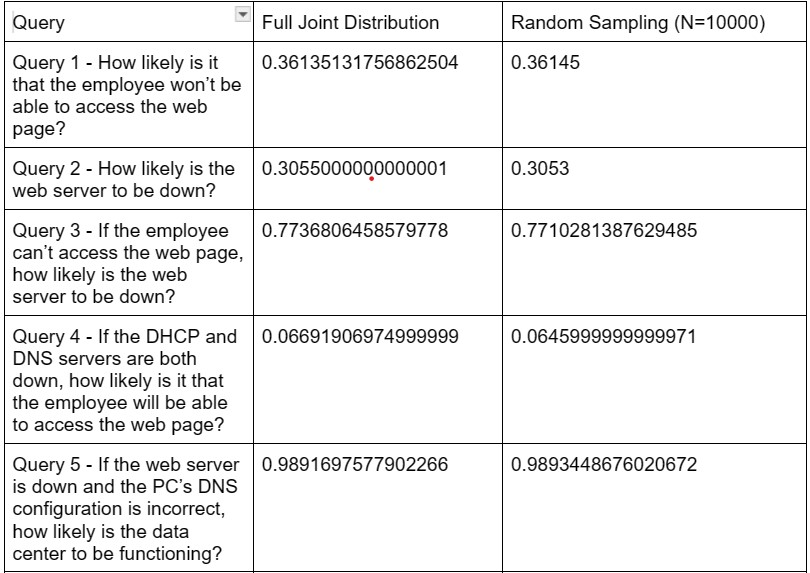

In the table above, if you look the values of the Full Joint Distribution and the values of the Random Sampling, they are quite close. With more samples, the random sampling algorithim values would get closer to the Full Joint Distribution

**Resources**

- Programming Platform - Visual Studio Code
- Programming Reference - Aima-python
- Diagram - Lucidchart
- Collaboration - Google Collab - Notebook, Github
